# Модель 14 (SqueezeNet + SeparebleConv2D) - НЕУДАЧНАЯ

#### Импорт необходимых библиотек

In [1]:
import sys

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Аугментация (4)

In [2]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

#### Скачиваем датасеты

In [3]:
train_ds, val_ds, test_ds = get_ds(
    'smote_data_train_7000', 'repaired_data_test',
    transform=transformer, one_hot=True, back=2, batch_size=100
)

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [4]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

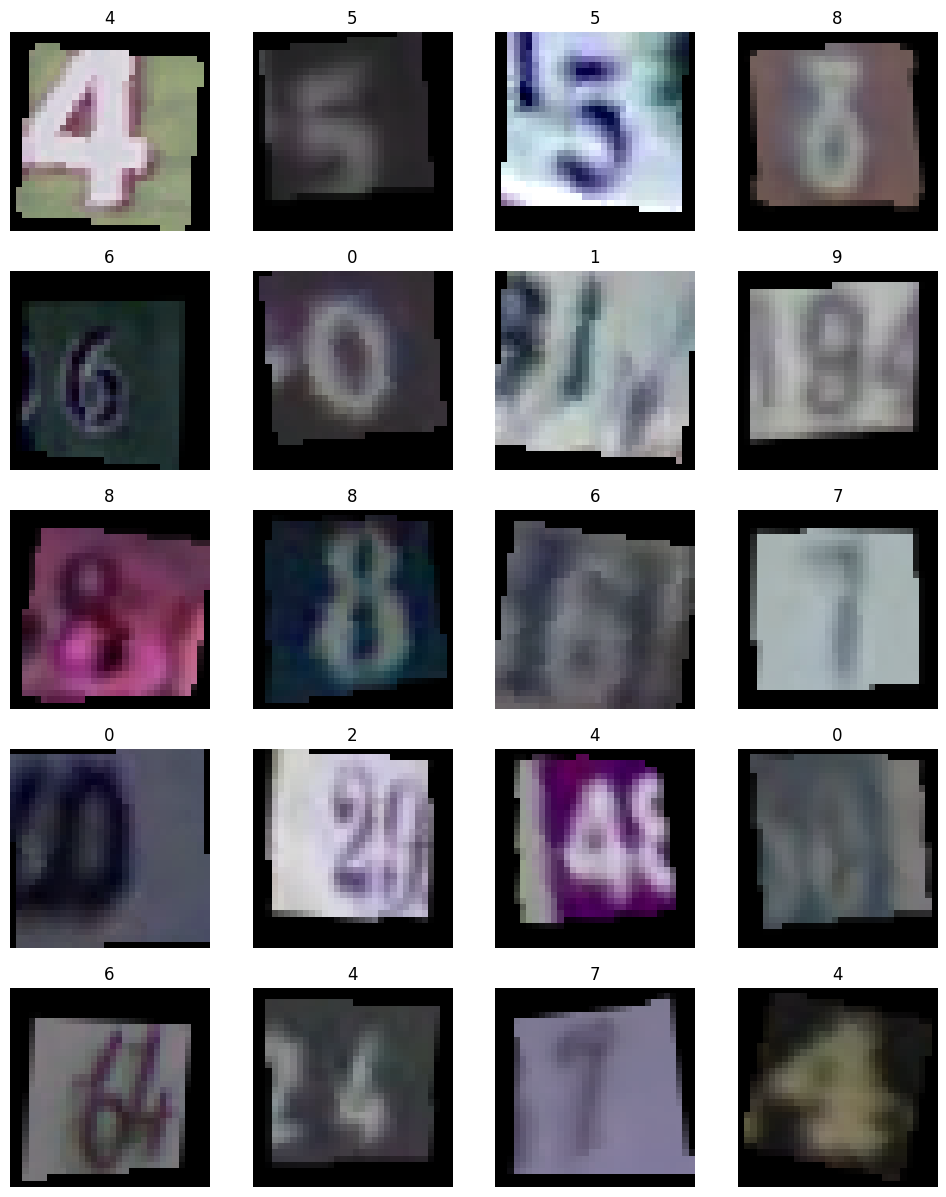

In [5]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

#### Пишем модель

In [6]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.SeparableConv2D(32, (3, 3), padding='same')(inputs)
x = tf.keras.layers.MaxPool2D(2)(x)

fork = tf.keras.layers.SeparableConv2D(64, (1, 1))(x)
branch1 = tf.keras.layers.SeparableConv2D(64, (1, 1))(fork)
branch2 = tf.keras.layers.SeparableConv2D(64, (3, 3), padding='same')(fork)
x = tf.keras.layers.add([branch1, branch2])

x = tf.keras.layers.AveragePooling2D(3, strides=2)(x)

fork = tf.keras.layers.SeparableConv2D(128, (1, 1))(x)
branch1 = tf.keras.layers.SeparableConv2D(128, (1, 1))(fork)
branch2 = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same')(fork)
x = tf.keras.layers.add([branch1, branch2])

fork = tf.keras.layers.SeparableConv2D(256, (1, 1))(x)
branch1 = tf.keras.layers.SeparableConv2D(256, (1, 1))(fork)
branch2 = tf.keras.layers.SeparableConv2D(256, (3, 3), padding='same')(fork)
x = tf.keras.layers.add([branch1, branch2])

x = tf.keras.layers.GlobalMaxPool2D()(x)

x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10)(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 separable_conv2d (SeparableCon  (None, 32, 32, 32)  155         ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['separable_conv2d[0][0]']       
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 16, 16, 64)  2144        ['max_pooling2d[0][0]']      

#### Создаем чекпоинты

In [7]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
num_model = '_g_15'
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    )
]

#### Компиляция модели

In [8]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam()),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

#### Обучаем модель

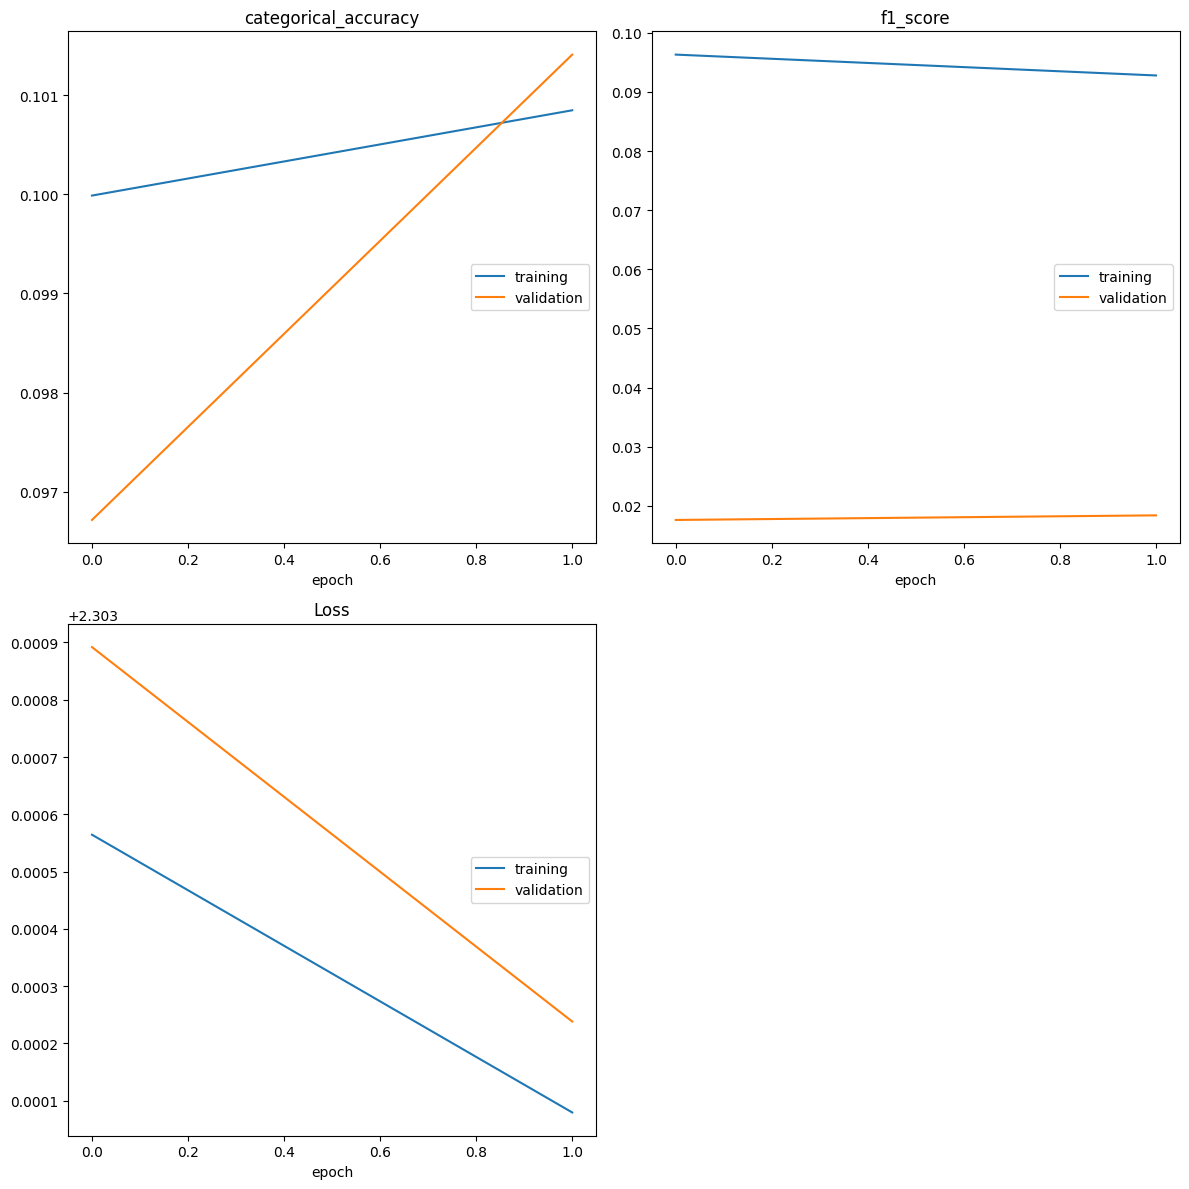

categorical_accuracy
	training         	 (min:    0.100, max:    0.101, cur:    0.101)
	validation       	 (min:    0.097, max:    0.101, cur:    0.101)
f1_score
	training         	 (min:    0.093, max:    0.096, cur:    0.093)
	validation       	 (min:    0.018, max:    0.018, cur:    0.018)
Loss
	training         	 (min:    2.303, max:    2.304, cur:    2.303)
	validation       	 (min:    2.303, max:    2.304, cur:    2.303)
651/651 [==============================] - 1100s 2s/step - loss: 2.3031 - categorical_accuracy: 0.1008 - f1_score: 0.0928 - val_loss: 2.3032 - val_categorical_accuracy: 0.1014 - val_f1_score: 0.0184
Epoch 3/100
146/651 [=====>........................] - ETA: 12:10 - loss: 2.3029 - categorical_accuracy: 0.1027 - f1_score: 0.0571

KeyboardInterrupt: 

In [9]:
model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

# ВЫВОД:
Графики обучения были утеряны.
Модель возможно бы дошла до хороших метрик, однако ее обучение шло крайне медленно. Squeeze архитектура и SeparebleConv2D несовместимы.